In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import pickle

In [2]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

2.1.0+cu121
PyTorch version: None , CUDA version: 12.1


In [3]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
# disable interactive plots
# %matplotlib inline

# enable interactive plots
%matplotlib notebook

In [5]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [6]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

In [7]:
num_layers = 7
max_angle = 1.*np.pi
feature_scale = 200.
xy_scale=100.

In [8]:
import numpy as np
import pandas as pd

def readMuonE():

    with open('/storage/MUonE/milosz/events3D.pickle', mode='rb') as f:
        events3D = pickle.load(f)
    
        layers_zs =  [832.0, 843.7, 1141.0, 1146.0, 1266.0, 1479.6, 1960.0, 1973.0]

        data_out = []
        for event in events3D:
            
            if event is None:
                continue
            
            X = None
            for hit_index, hit in enumerate(event):
                if hit_index == 0:
                    X = np.array([[hit[1]*xy_scale, hit[2]*xy_scale, hit[3], hit[0]]])
                else:
                    X = np.append(X, np.array([[hit[1]*xy_scale, hit[2]*xy_scale, hit[3], hit[0]]]), axis=0)
                    
            e = []
            for layer in np.arange(num_layers - 1):
                for i in np.argwhere(X[:, 3] == layers_zs[layer + 1]):
                    for j in np.argwhere(X[:, 3] == layers_zs[layer + 2]):
                        delta_z = layers_zs[layer + 2] - layers_zs[layer + 1]
                        delta = np.tan(max_angle / 2) * delta_z
                        if (X[i, 0] - delta < X[j, 0] < X[i, 0] + delta) and (X[i, 1] - delta < X[j, 1] < X[i, 1] + delta):
                            e.append([i, j])
            e = np.array(e).T.squeeze()
            
            try:
                y = np.array([int(i[2] == j[2]) for i,j in zip(X[e[0]], X[e[1]])])
            except:
                # handle no edges created
                continue
            
            X = np.array([X[:,3], X[:,0], X[:,1]]).T / feature_scale

            data_event = Data(x = torch.from_numpy(X).float(),
                             edge_index = torch.from_numpy(e),
                             y = torch.from_numpy(y),
                             pid = torch.from_numpy(np.array([X[:,1], X[:,2]])))

            data_out.append(data_event)
        
        return data_out

In [9]:
def plot_3D_graph(event):
    
    '''
    print(event)
    print(event.x)
    print(event.edge_index)
    print(event.y)
    print(event.pid)
    '''

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    
    z = event.x[:, 0].numpy()
    x = event.x[:, 1].numpy()
    y = event.x[:, 2].numpy()
    edges = event.edge_index.t().numpy()

    ax.scatter(z, x, y, c='k')
    
    for e in edges:
        ax.plot([z[e[0]], z[e[1]]], [x[e[0]], x[e[1]]], [y[e[0]], y[e[1]]], c='k', lw=1)
    
    plt.show()

Fake / True =  1.0
Training dataset (events):  74077
Test dataset (events):  18520


/home/jupyter-dmizera/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<IPython.core.display.Javascript object>


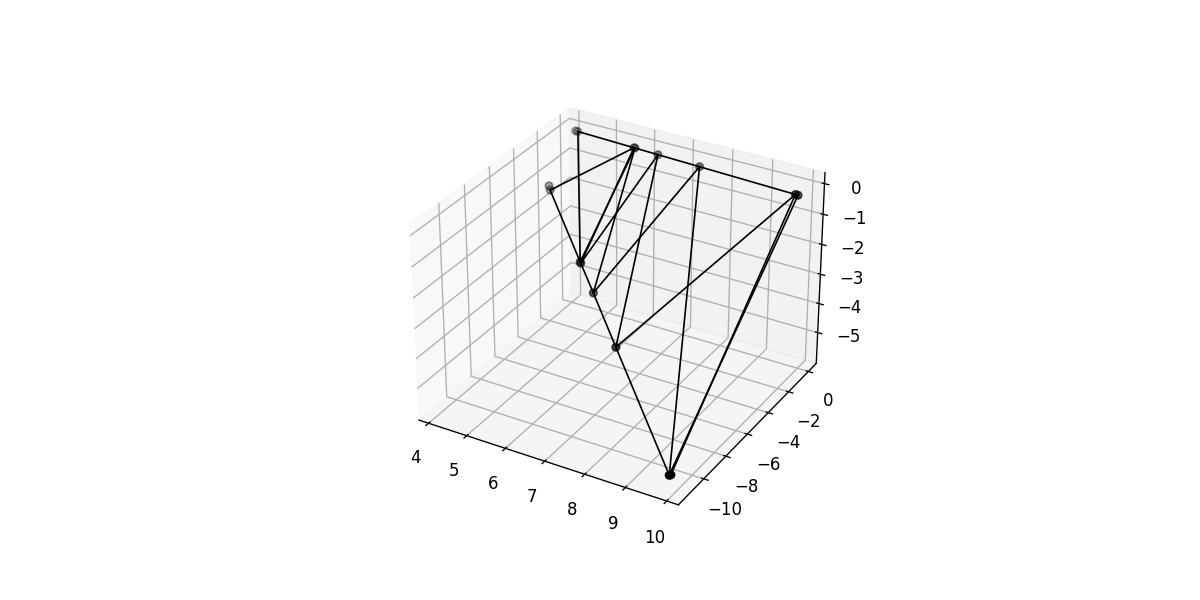

<IPython.core.display.Javascript object>


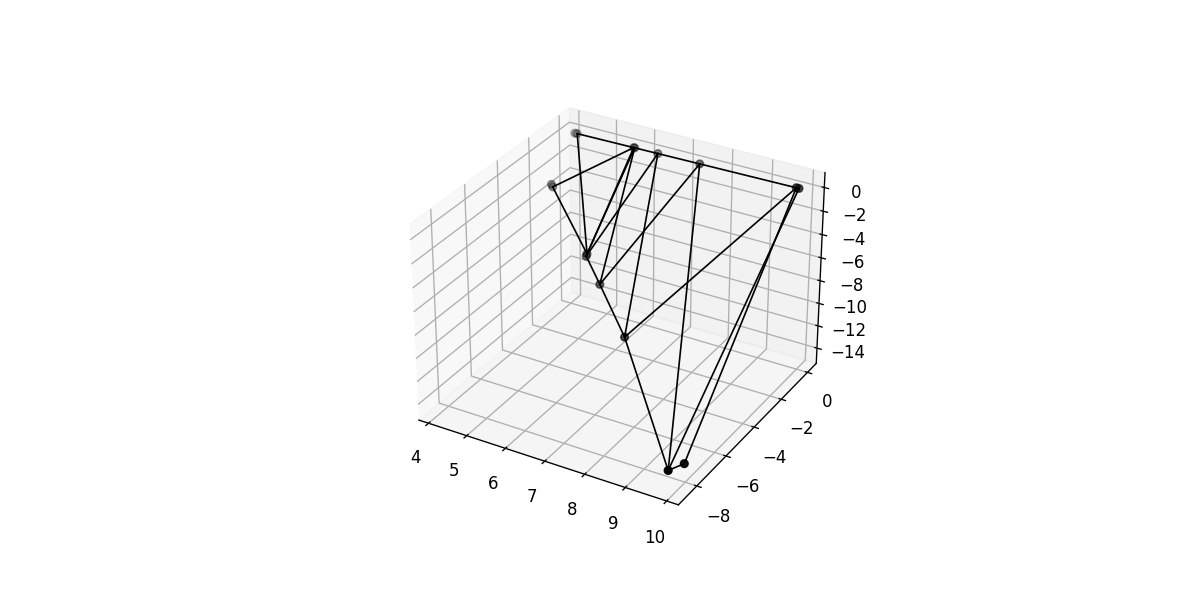

<IPython.core.display.Javascript object>


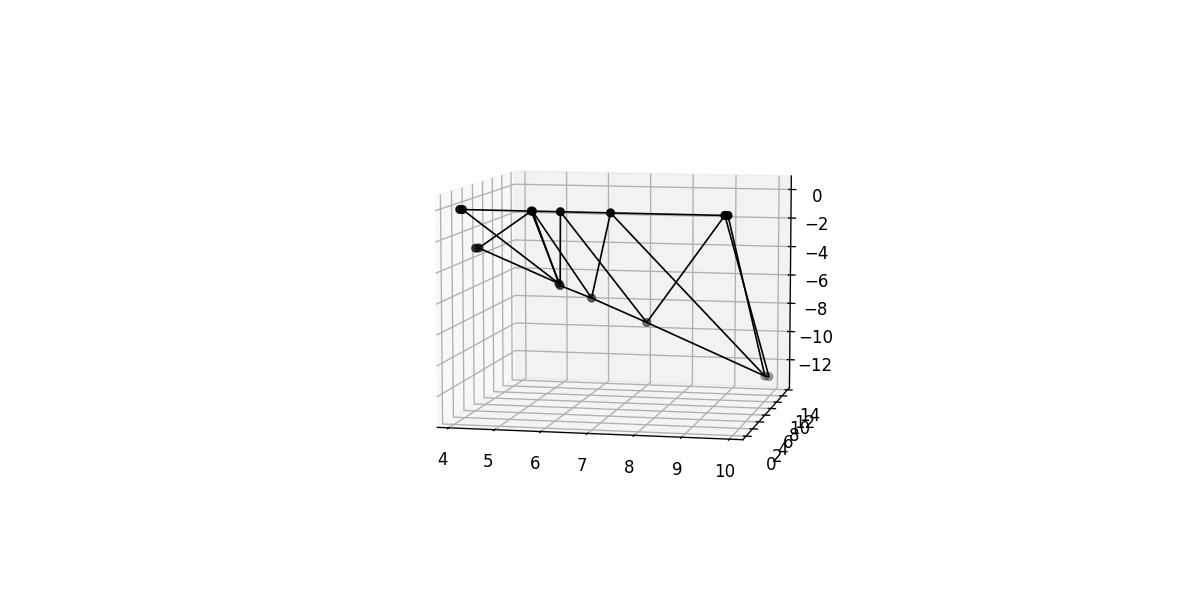

<IPython.core.display.Javascript object>


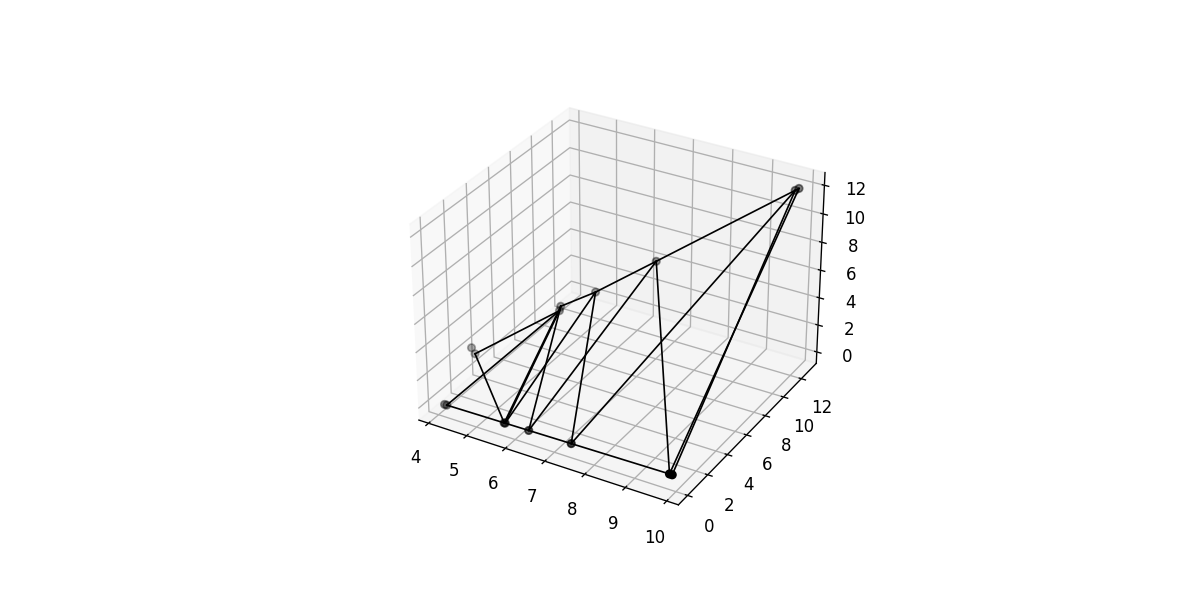

<IPython.core.display.Javascript object>


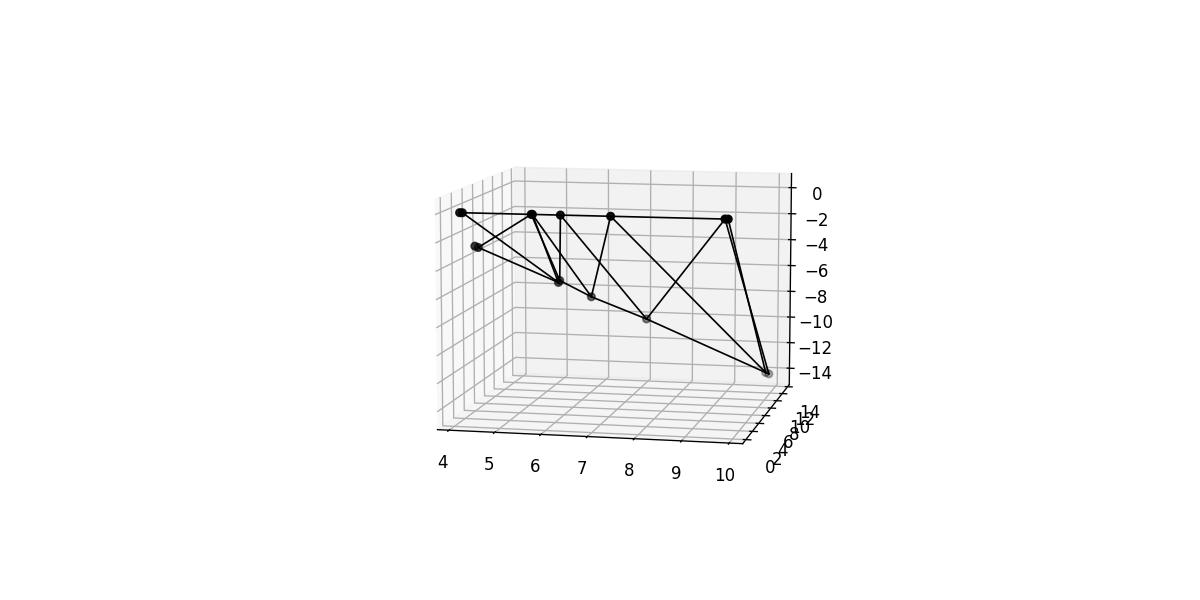

In [10]:
# read data and prepare for training
data = readMuonE()

# split data into training and test datasets
random.shuffle(data)
split_index = int(0.8 * len(data))
train_dataset = data[:split_index]
test_dataset = data[split_index:]
    
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("Training dataset (events): ", len(train_dataset))
print("Test dataset (events): ", len(test_dataset))

# display few events
for k in range(5):
    plot_3D_graph(train_loader.dataset[k])

In [11]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

In [12]:
weight = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 3, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)

for epoch in range(50):
    ep += 1
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))

Epoch: 1, Accuracy: 0.9984
Epoch: 2, Accuracy: 0.9993
Epoch: 3, Accuracy: 0.9991
Epoch: 4, Accuracy: 0.9992
Epoch: 5, Accuracy: 0.9994
Epoch: 6, Accuracy: 0.9993
Epoch: 7, Accuracy: 0.9993
Epoch: 8, Accuracy: 0.9993
Epoch: 9, Accuracy: 0.9995
Epoch: 10, Accuracy: 0.9994
Epoch: 11, Accuracy: 0.9991
Epoch: 12, Accuracy: 0.9994
Epoch: 13, Accuracy: 0.9995
Epoch: 14, Accuracy: 0.9993
Epoch: 15, Accuracy: 0.9995
Epoch: 16, Accuracy: 0.9995
Epoch: 17, Accuracy: 0.9995
Epoch: 18, Accuracy: 0.9992
Epoch: 19, Accuracy: 0.9995
Epoch: 20, Accuracy: 0.9996
Epoch: 21, Accuracy: 0.9995
Epoch: 22, Accuracy: 0.9997
Epoch: 23, Accuracy: 0.9995
Epoch: 24, Accuracy: 0.9994
Epoch: 25, Accuracy: 0.9997
Epoch: 26, Accuracy: 0.9991
Epoch: 27, Accuracy: 0.9993
Epoch: 28, Accuracy: 0.9989
Epoch: 29, Accuracy: 0.9995
Epoch: 30, Accuracy: 0.9996
Epoch: 31, Accuracy: 0.9997
Epoch: 32, Accuracy: 0.9996
Epoch: 33, Accuracy: 0.9998
Epoch: 34, Accuracy: 0.9995
Epoch: 35, Accuracy: 0.9997
Epoch: 36, Accuracy: 0.9996
E

<IPython.core.display.Javascript object>


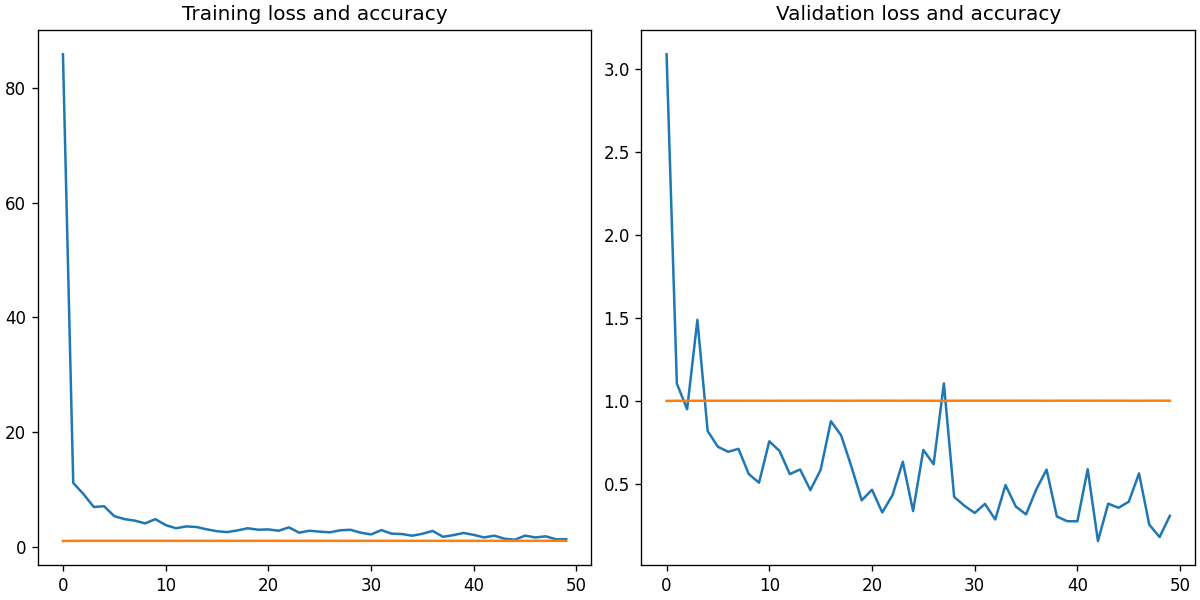

In [13]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, np.arange(len(t_acc_v)), t_acc_v)
axs[0].set_title("Training loss and accuracy")
axs[0].set_yscale("linear")
axs[1].plot(np.arange(len(v_loss_v)), v_loss_v, np.arange(len(v_acc_v)), v_acc_v)
axs[1].set_title("Validation loss and accuracy")
axs[1].set_yscale("linear")

In [14]:
def plot_3D_classified(event, preds, cut=0.5):
    
    '''
    print(event)
    print(event.x)
    print(event.edge_index)
    print(event.y)
    print(event.pid)
    gprint(preds)
    '''

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    z = event.x[:, 0].numpy()
    x = event.x[:, 1].numpy()
    y = event.x[:, 2].numpy()
    edges = event.edge_index.t().numpy()
    labels = event.y
    preds = preds.detach().numpy()
    
    ax.scatter(z, x, y, c='k')

    for j in range(len(labels)):
        
        s = str('%01.2f' % preds[j]) + '/' + str(labels[j].item())
        ax.text(((z[edges[j,0]] + z[edges[j,1]]) / 2.),
                ((x[edges[j,0]] + x[edges[j,1]]) / 2.),
                ((y[edges[j,0]] + y[edges[j,1]]) / 2.),
                s, fontsize=8)
        
        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([z[edges[j,0]], z[edges[j,1]]],
                     [x[edges[j,0]], x[edges[j,1]]],
                     [y[edges[j,0]], y[edges[j,1]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([z[edges[j,0]], z[edges[j,1]]],
                     [x[edges[j,0]], x[edges[j,1]]],
                     [y[edges[j,0]], y[edges[j,1]]],
                     '-', c='r')

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([z[edges[j,0]], z[edges[j,1]]],
                     [x[edges[j,0]], x[edges[j,1]]],
                     [y[edges[j,0]], y[edges[j,1]]],
                     '-', c='k', alpha=0.3 + 0.5*preds[j])

        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([z[edges[j,0]], z[edges[j,1]]],
                     [x[edges[j,0]], x[edges[j,1]]],
                     [y[edges[j,0]], y[edges[j,1]]],
                     '--', c='k', alpha=0.3 + 0.5*preds[j])

<IPython.core.display.Javascript object>


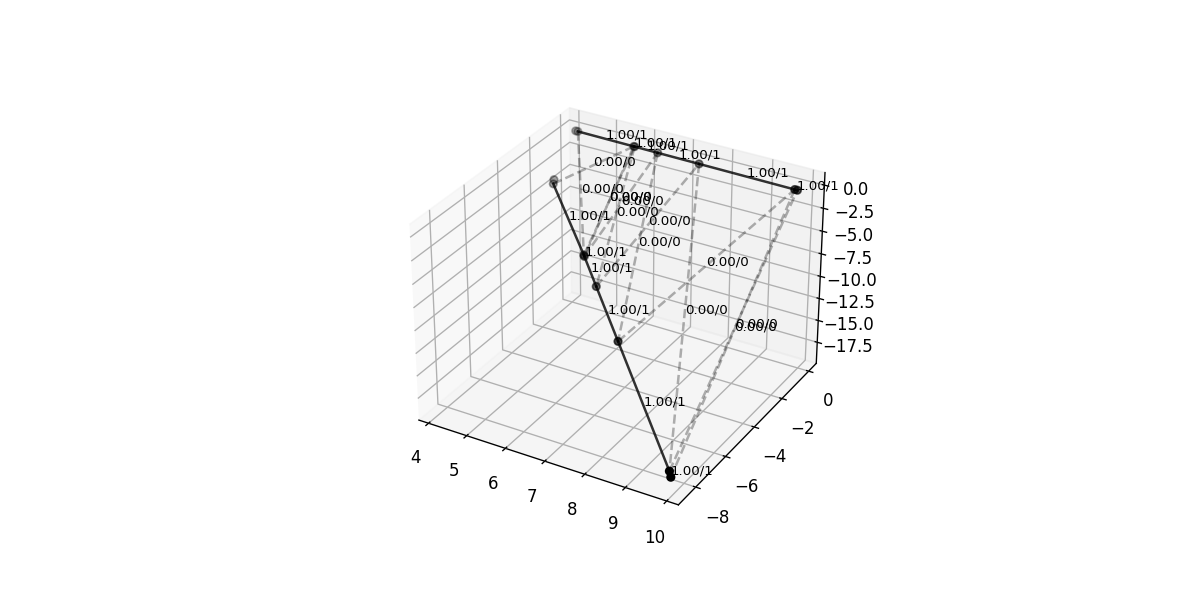

<IPython.core.display.Javascript object>


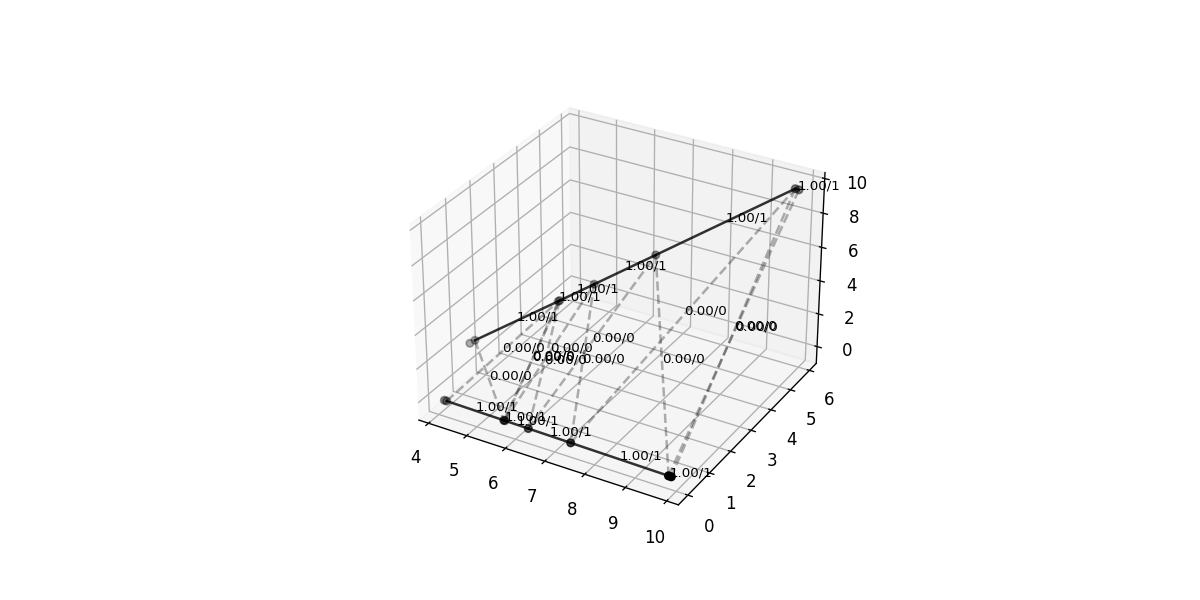

<IPython.core.display.Javascript object>


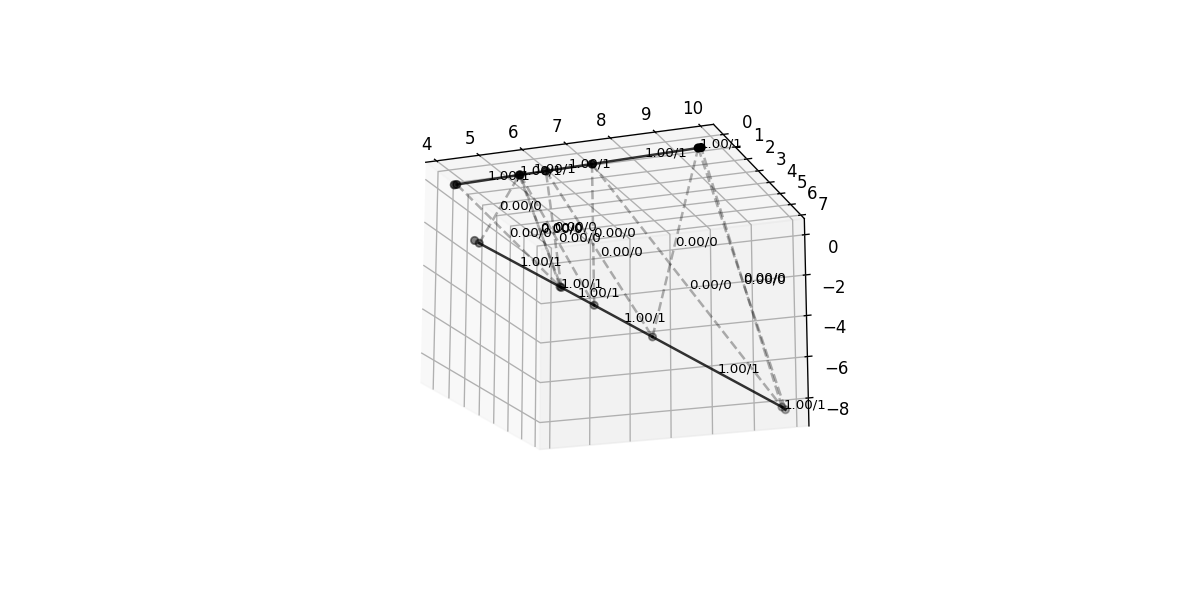

<IPython.core.display.Javascript object>


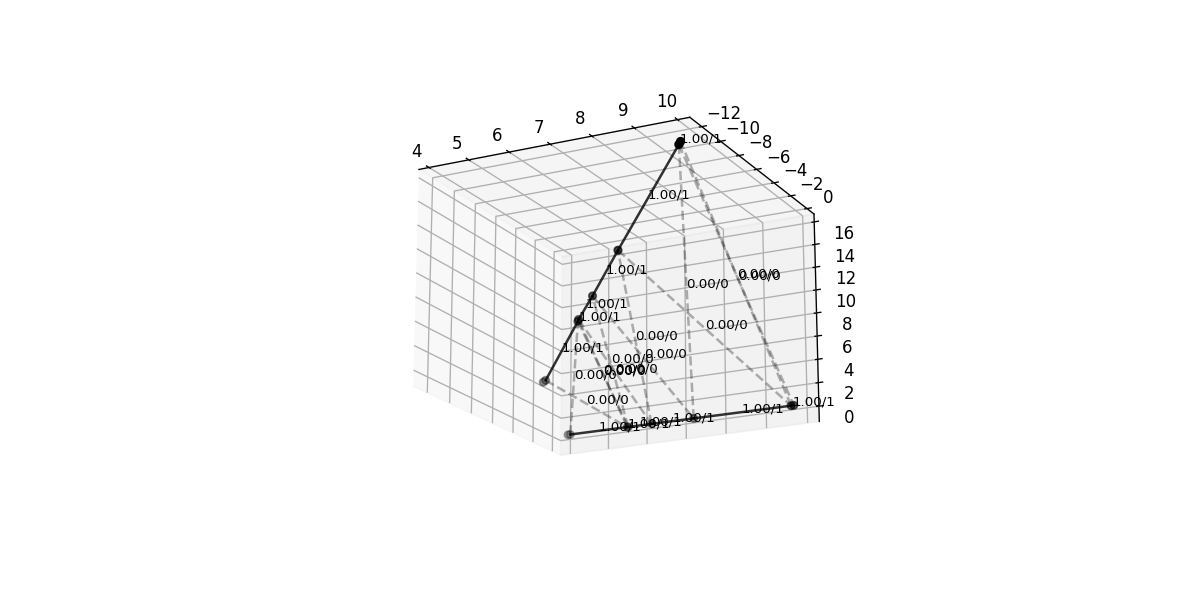

<IPython.core.display.Javascript object>


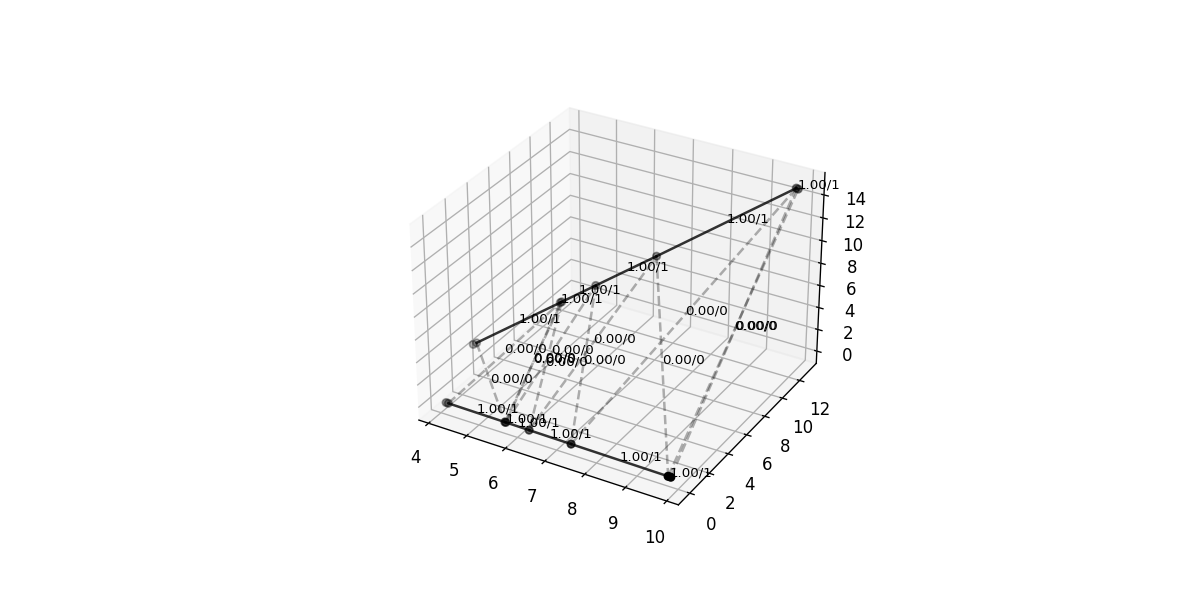

<IPython.core.display.Javascript object>


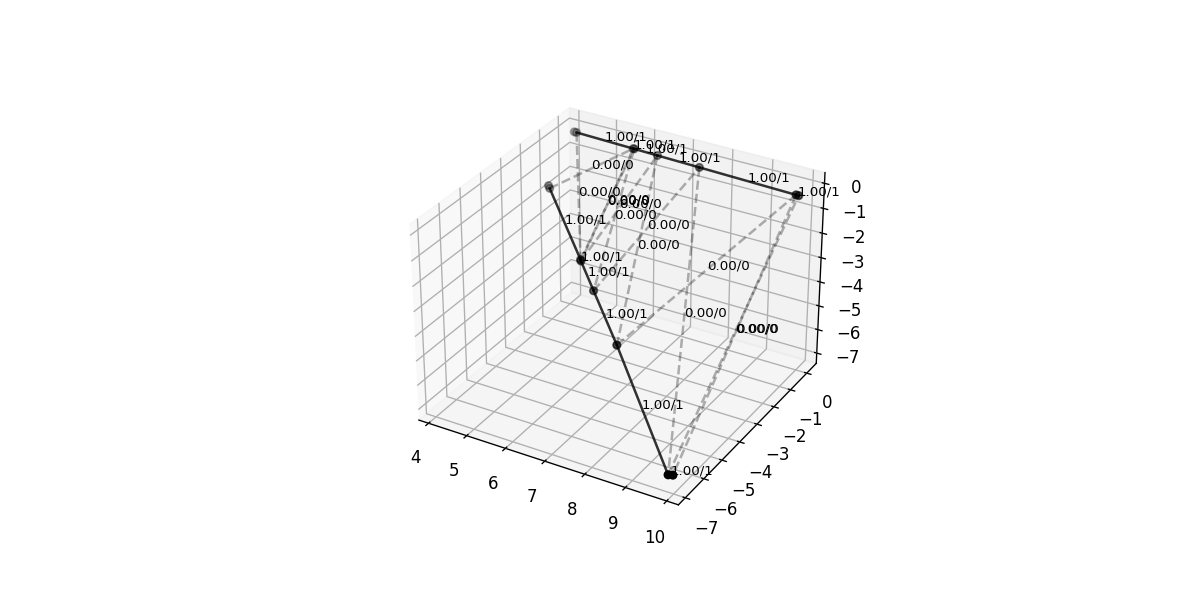

<IPython.core.display.Javascript object>


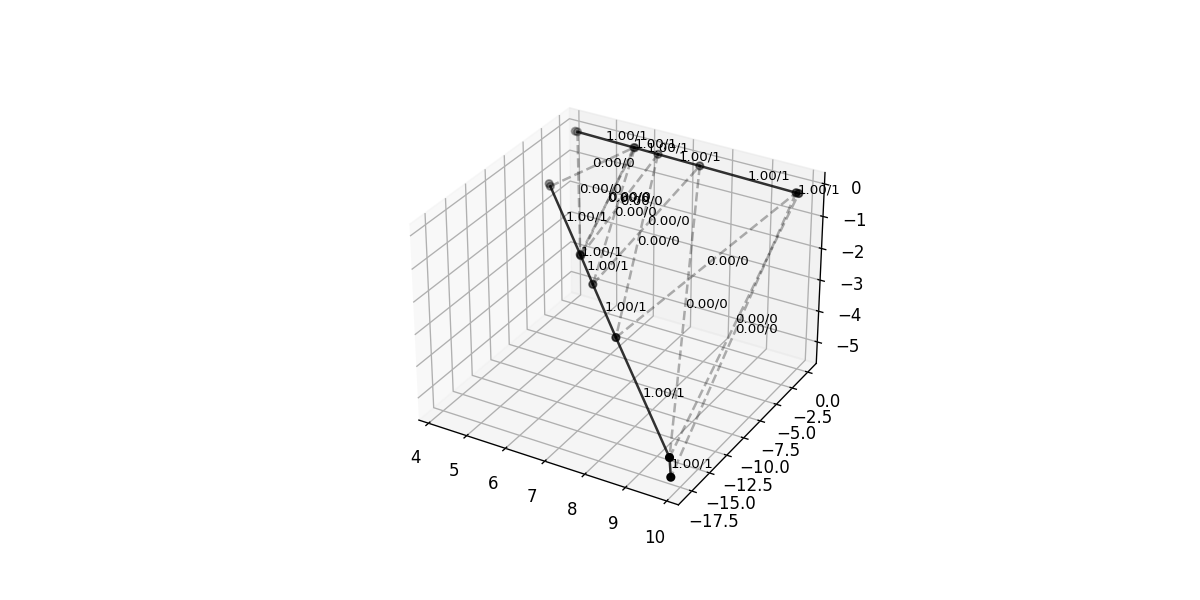

<IPython.core.display.Javascript object>


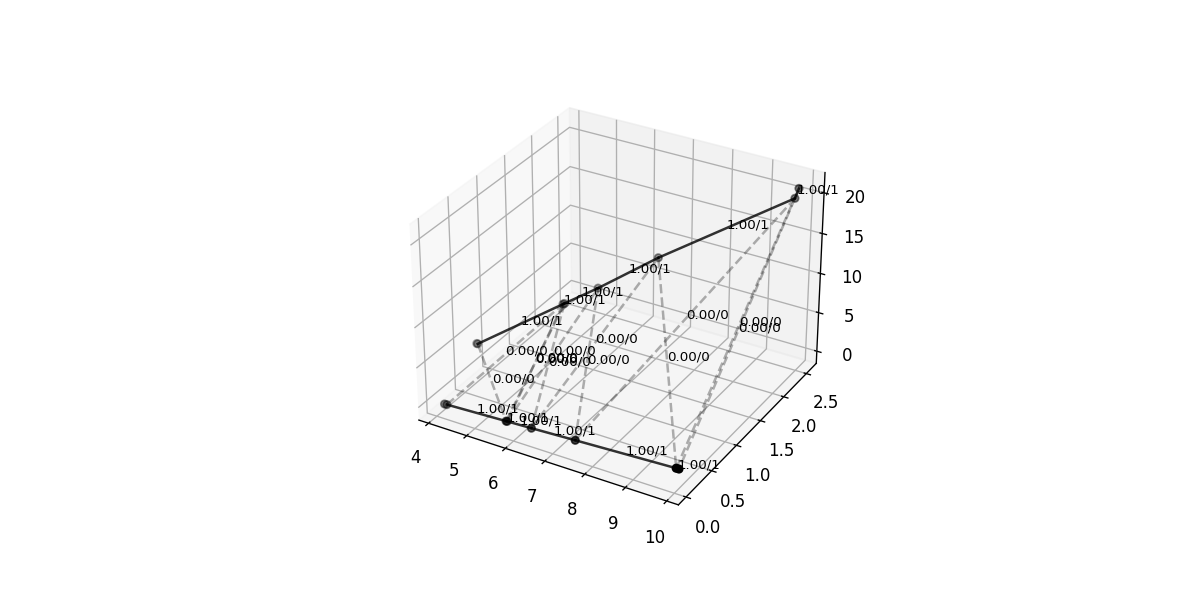

<IPython.core.display.Javascript object>


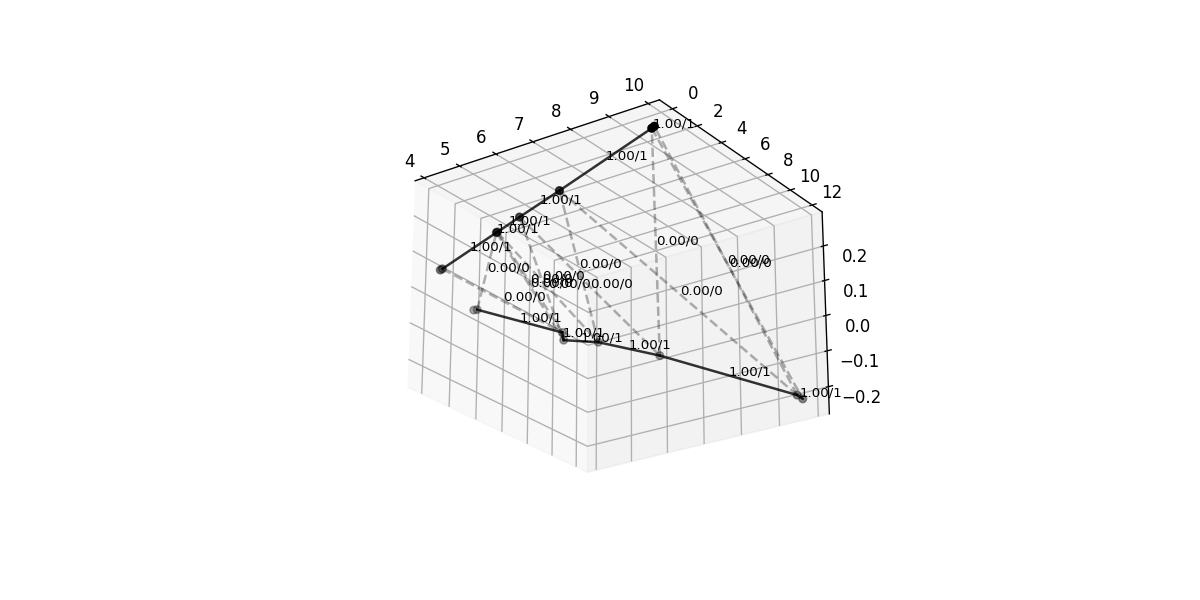

<IPython.core.display.Javascript object>


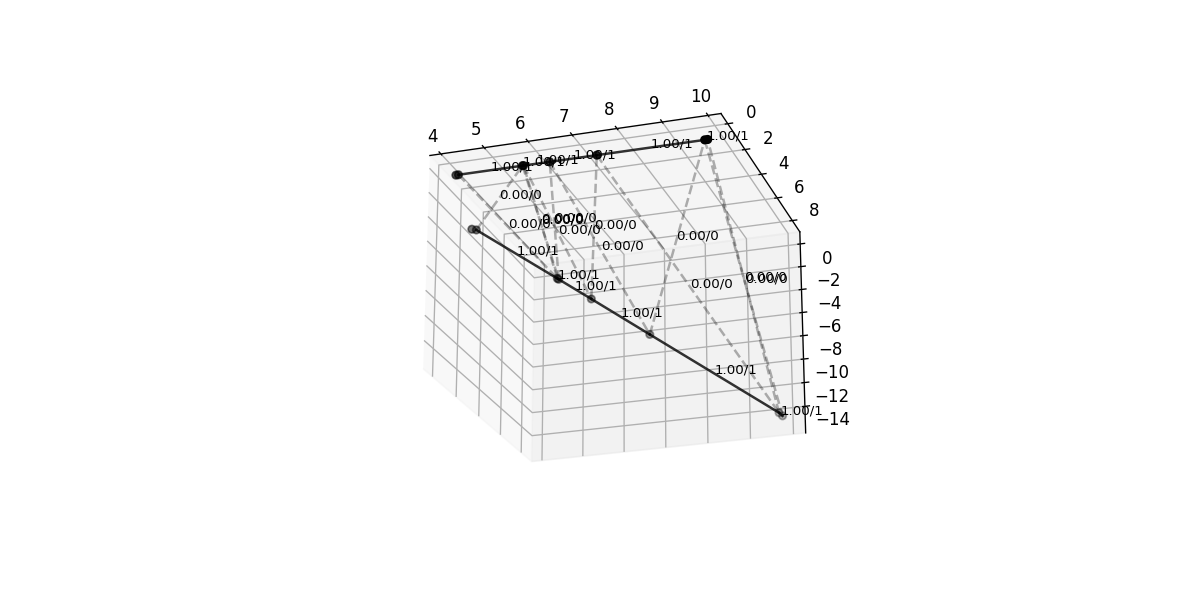

In [15]:
for k in range(10):
    data = test_loader.dataset[k].to(device)
    preds = torch.sigmoid(model(data)).to('cpu')
    plot_3D_classified(data.to('cpu'), preds)